# Step 8: Interpretability (SHAP Values)

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')

BASE_PATH = Path('/home/alvaro-ibarra/smartwatch-stress-detection')
COMBINED_PATH = BASE_PATH / 'data' / 'processed' / 'combined'
MODELS_PATH = BASE_PATH / 'outputs' / 'models'
OUTPUT_PATH = BASE_PATH / 'outputs' / 'tables'
FIGURES_PATH = BASE_PATH / 'outputs' / 'figures'

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

print("Libraries loaded")

Libraries loaded


/home/alvaro-ibarra/miniconda/envs/jupyter-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data and models
df = pd.read_csv(COMBINED_PATH / 'combined_dataset_filled.csv')
print(f"Dataset: {df.shape[0]} windows")

metadata_cols = ['subject_id', 'dataset', 'window_id', 'timestamp_start', 'timestamp_end', 'label']
feature_cols = [c for c in df.columns if c not in metadata_cols]
print(f"Features: {len(feature_cols)}")

X = df[feature_cols].values
y = df['label'].values

# Load models
xgb_model = joblib.load(MODELS_PATH / 'xgboost.pkl')
rf_model = joblib.load(MODELS_PATH / 'random_forest.pkl')
le = joblib.load(MODELS_PATH / 'label_encoder.pkl')
scaler = joblib.load(MODELS_PATH / 'feature_scaler.pkl')

X_scaled = scaler.transform(X)
y_encoded = le.transform(y)

# Create DataFrame for SHAP
X_df = pd.DataFrame(X_scaled, columns=feature_cols)

print(f"Classes: {le.classes_}")

Dataset: 10511 windows
Features: 39
Classes: ['Aerobic' 'Amusement' 'Anaerobic' 'Baseline' 'Emotion' 'Stress']


In [3]:
# 8.1 SHAP Values for XGBoost (Best Model)
print("="*60)
print("8.1 SHAP VALUES FOR XGBOOST")
print("="*60)

# Use sample for computation efficiency
np.random.seed(42)
sample_idx = np.random.choice(len(X_df), size=min(1000, len(X_df)), replace=False)
X_sample = X_df.iloc[sample_idx]

print(f"Computing SHAP values for {len(X_sample)} samples...")

# TreeExplainer for XGBoost
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_sample)

print(f"SHAP values shape: {np.array(shap_values_xgb).shape}")

8.1 SHAP VALUES FOR XGBOOST
Computing SHAP values for 1000 samples...
SHAP values shape: (1000, 39, 6)


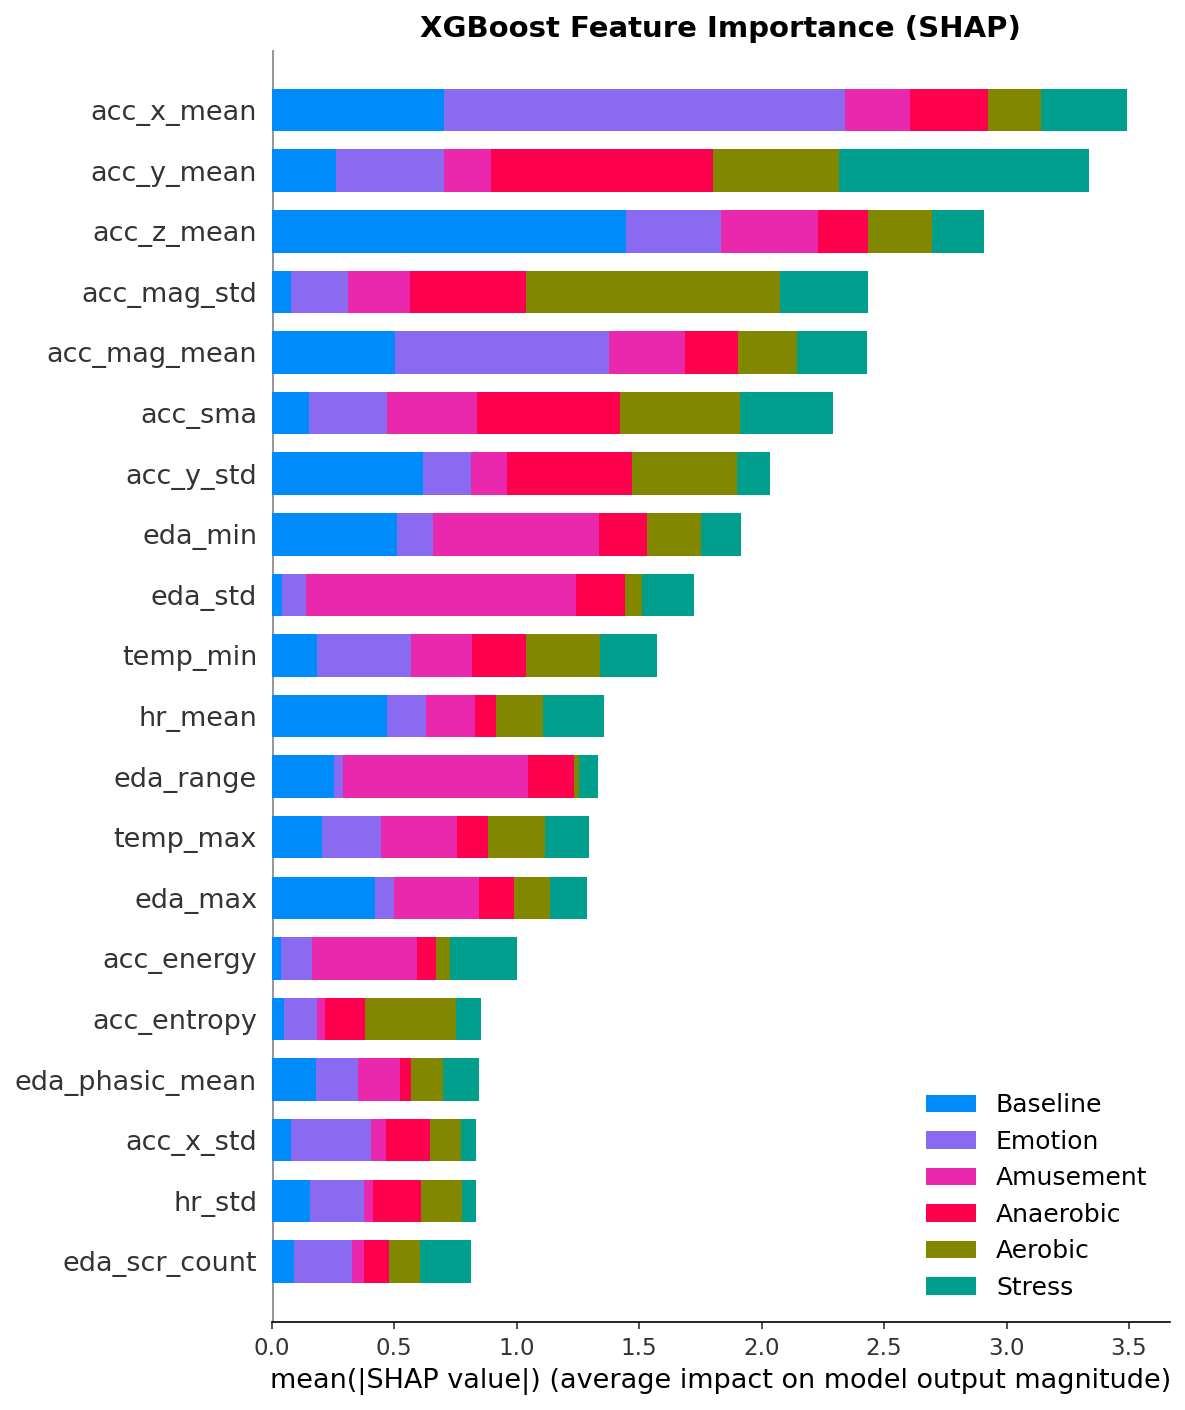

In [4]:
# SHAP Summary Plot (all classes)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_xgb, X_sample, plot_type="bar", 
                  class_names=le.classes_, show=False, max_display=20)
plt.title('XGBoost Feature Importance (SHAP)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH / 'shap_summary_bar.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# SHAP Beeswarm plot for each class - simplified version
# Create individual plots for each class
for i, class_name in enumerate(le.classes_):
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_xgb[:, :, i], X_sample, show=False, max_display=10)
    plt.title(f'SHAP Values - {class_name}', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig(FIGURES_PATH / f'shap_class_{class_name.lower()}.png', dpi=300, bbox_inches='tight')
    plt.close()

print(f"Saved SHAP plots for {len(le.classes_)} classes\")")

Saved SHAP plots for 6 classes")


In [9]:
# Mean absolute SHAP values per feature per class
# shap_values_xgb has shape (n_samples, n_features, n_classes)
shap_importance = {}
for i, class_name in enumerate(le.classes_):
    mean_abs_shap = np.abs(shap_values_xgb[:, :, i]).mean(axis=0)
    shap_importance[class_name] = mean_abs_shap

shap_df = pd.DataFrame(shap_importance, index=feature_cols)
shap_df['Overall'] = shap_df.mean(axis=1)
shap_df = shap_df.sort_values('Overall', ascending=False)

# Save SHAP importance
shap_df.to_csv(OUTPUT_PATH / 'shap_importance_by_class.csv')

print("\\nTop 15 Features by SHAP Importance:")
print(shap_df.head(15).round(4).to_string())

\nTop 15 Features by SHAP Importance:
              Aerobic  Amusement  Anaerobic  Baseline  Emotion  Stress  Overall
acc_x_mean     0.2130     0.2628     0.3210    0.7037   1.6387  0.3536   0.5821
acc_y_mean     0.5128     0.1917     0.9057    0.2637   0.4413  1.0222   0.5562
acc_z_mean     0.2596     0.3967     0.2042    1.4472   0.3864  0.2156   0.4850
acc_mag_std    1.0384     0.2551     0.4702    0.0787   0.2324  0.3605   0.4059
acc_mag_mean   0.2383     0.3108     0.2194    0.5029   0.8724  0.2864   0.4050
acc_sma        0.4928     0.3658     0.5820    0.1519   0.3204  0.3774   0.3817
acc_y_std      0.4299     0.1458     0.5100    0.6178   0.1962  0.1333   0.3388
eda_min        0.2197     0.6805     0.1948    0.5129   0.1437  0.1648   0.3194
eda_std        0.0717     1.1020     0.1990    0.0441   0.0965  0.2092   0.2871
temp_min       0.3012     0.2517     0.2208    0.1865   0.3804  0.2314   0.2620
hr_mean        0.1939     0.2038     0.0837    0.4716   0.1566  0.2472   0.2261
ed

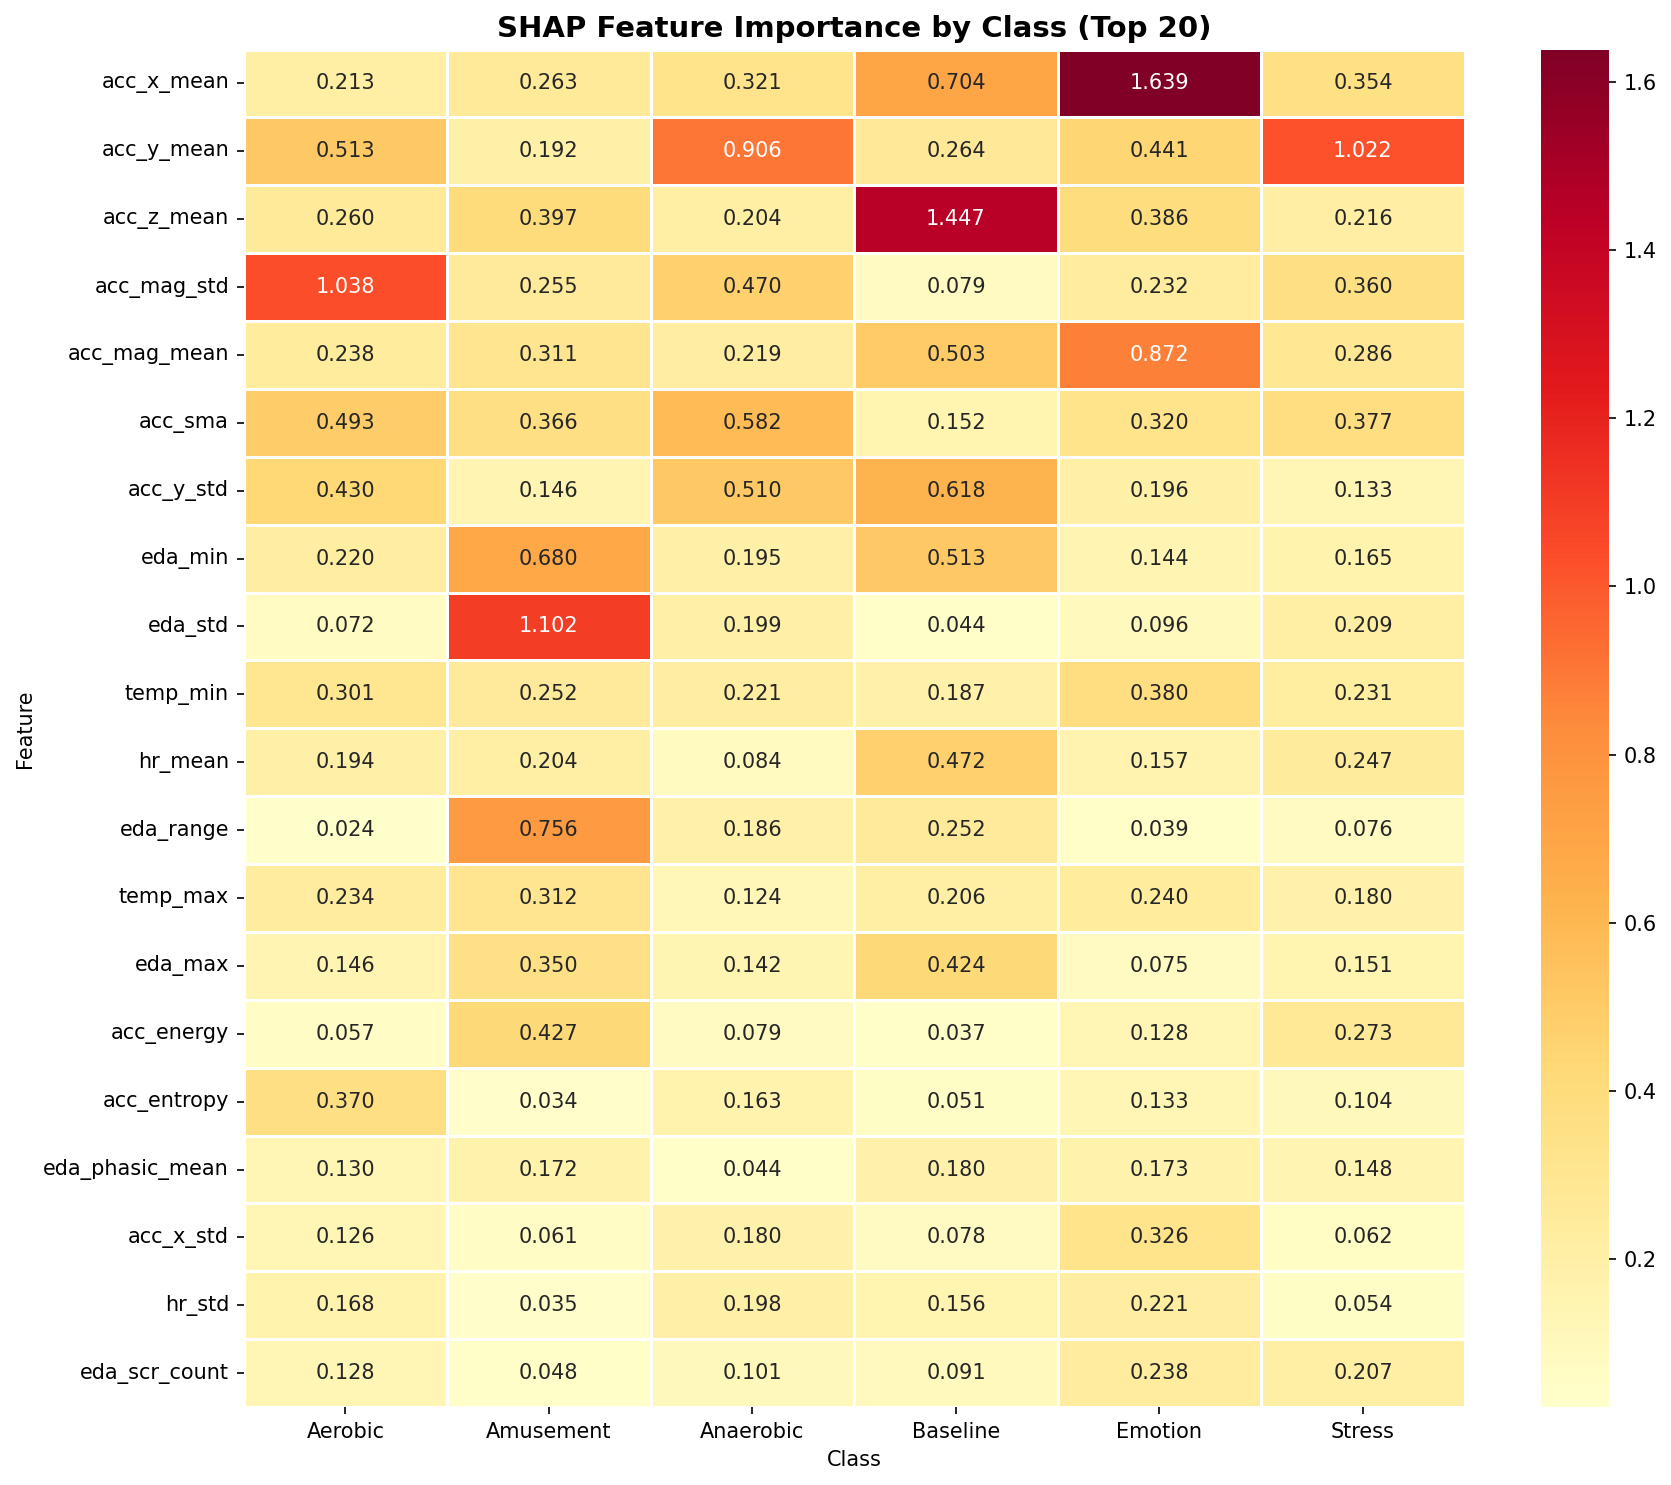

In [10]:
# Heatmap of SHAP importance by class
plt.figure(figsize=(12, 10))
sns.heatmap(shap_df.head(20).drop('Overall', axis=1), annot=True, fmt='.3f', 
            cmap='YlOrRd', linewidths=0.5)
plt.title('SHAP Feature Importance by Class (Top 20)', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig(FIGURES_PATH / 'shap_heatmap_by_class.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# 8.2 Individual Prediction Explanations
print("\n" + "="*60)
print("8.2 INDIVIDUAL PREDICTION EXPLANATIONS")
print("="*60)

# Select one sample from each class
example_indices = []
for class_name in le.classes_:
    class_idx = np.where(y == class_name)[0][0]
    example_indices.append(class_idx)

print(f"Example indices: {example_indices}")


8.2 INDIVIDUAL PREDICTION EXPLANATIONS
Example indices: [np.int64(6748), np.int64(75), np.int64(8891), np.int64(0), np.int64(1305), np.int64(49)]


In [12]:
# Force plot for one example per class
shap.initjs()

# Compute SHAP for examples
X_examples = X_df.iloc[example_indices]
shap_examples = explainer_xgb.shap_values(X_examples)

print("Generating waterfall plots for each class...")

Generating waterfall plots for each class...


In [13]:
# Waterfall plots for each class example - save separately
for i, (idx, class_name) in enumerate(zip(example_indices, le.classes_)):
    # Get predicted class
    pred_class = le.classes_[xgb_model.predict(X_df.iloc[[idx]])[0]]
    pred_class_idx = list(le.classes_).index(pred_class)
    
    # Create explanation object
    exp = shap.Explanation(
        values=shap_examples[:, :, pred_class_idx][i],
        base_values=explainer_xgb.expected_value[pred_class_idx],
        data=X_examples.iloc[i].values,
        feature_names=feature_cols
    )
    
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(exp, max_display=10, show=False)
    plt.title(f'True: {class_name} | Pred: {pred_class}', fontsize=11, fontweight='bold')
    plt.tight_layout()
    plt.savefig(FIGURES_PATH / f'shap_waterfall_{class_name.lower()}.png', dpi=300, bbox_inches='tight')
    plt.close()

print(f"Saved waterfall plots for {len(le.classes_)} examples\")")

Saved waterfall plots for 6 examples")


In [14]:
# 8.3 Feature Interaction Analysis
print("\n" + "="*60)
print("8.3 FEATURE INTERACTION ANALYSIS")
print("="*60)

# Top features for interaction analysis
top_features = shap_df.head(5).index.tolist()
print(f"Analyzing interactions for: {top_features}")


8.3 FEATURE INTERACTION ANALYSIS
Analyzing interactions for: ['acc_x_mean', 'acc_y_mean', 'acc_z_mean', 'acc_mag_std', 'acc_mag_mean']


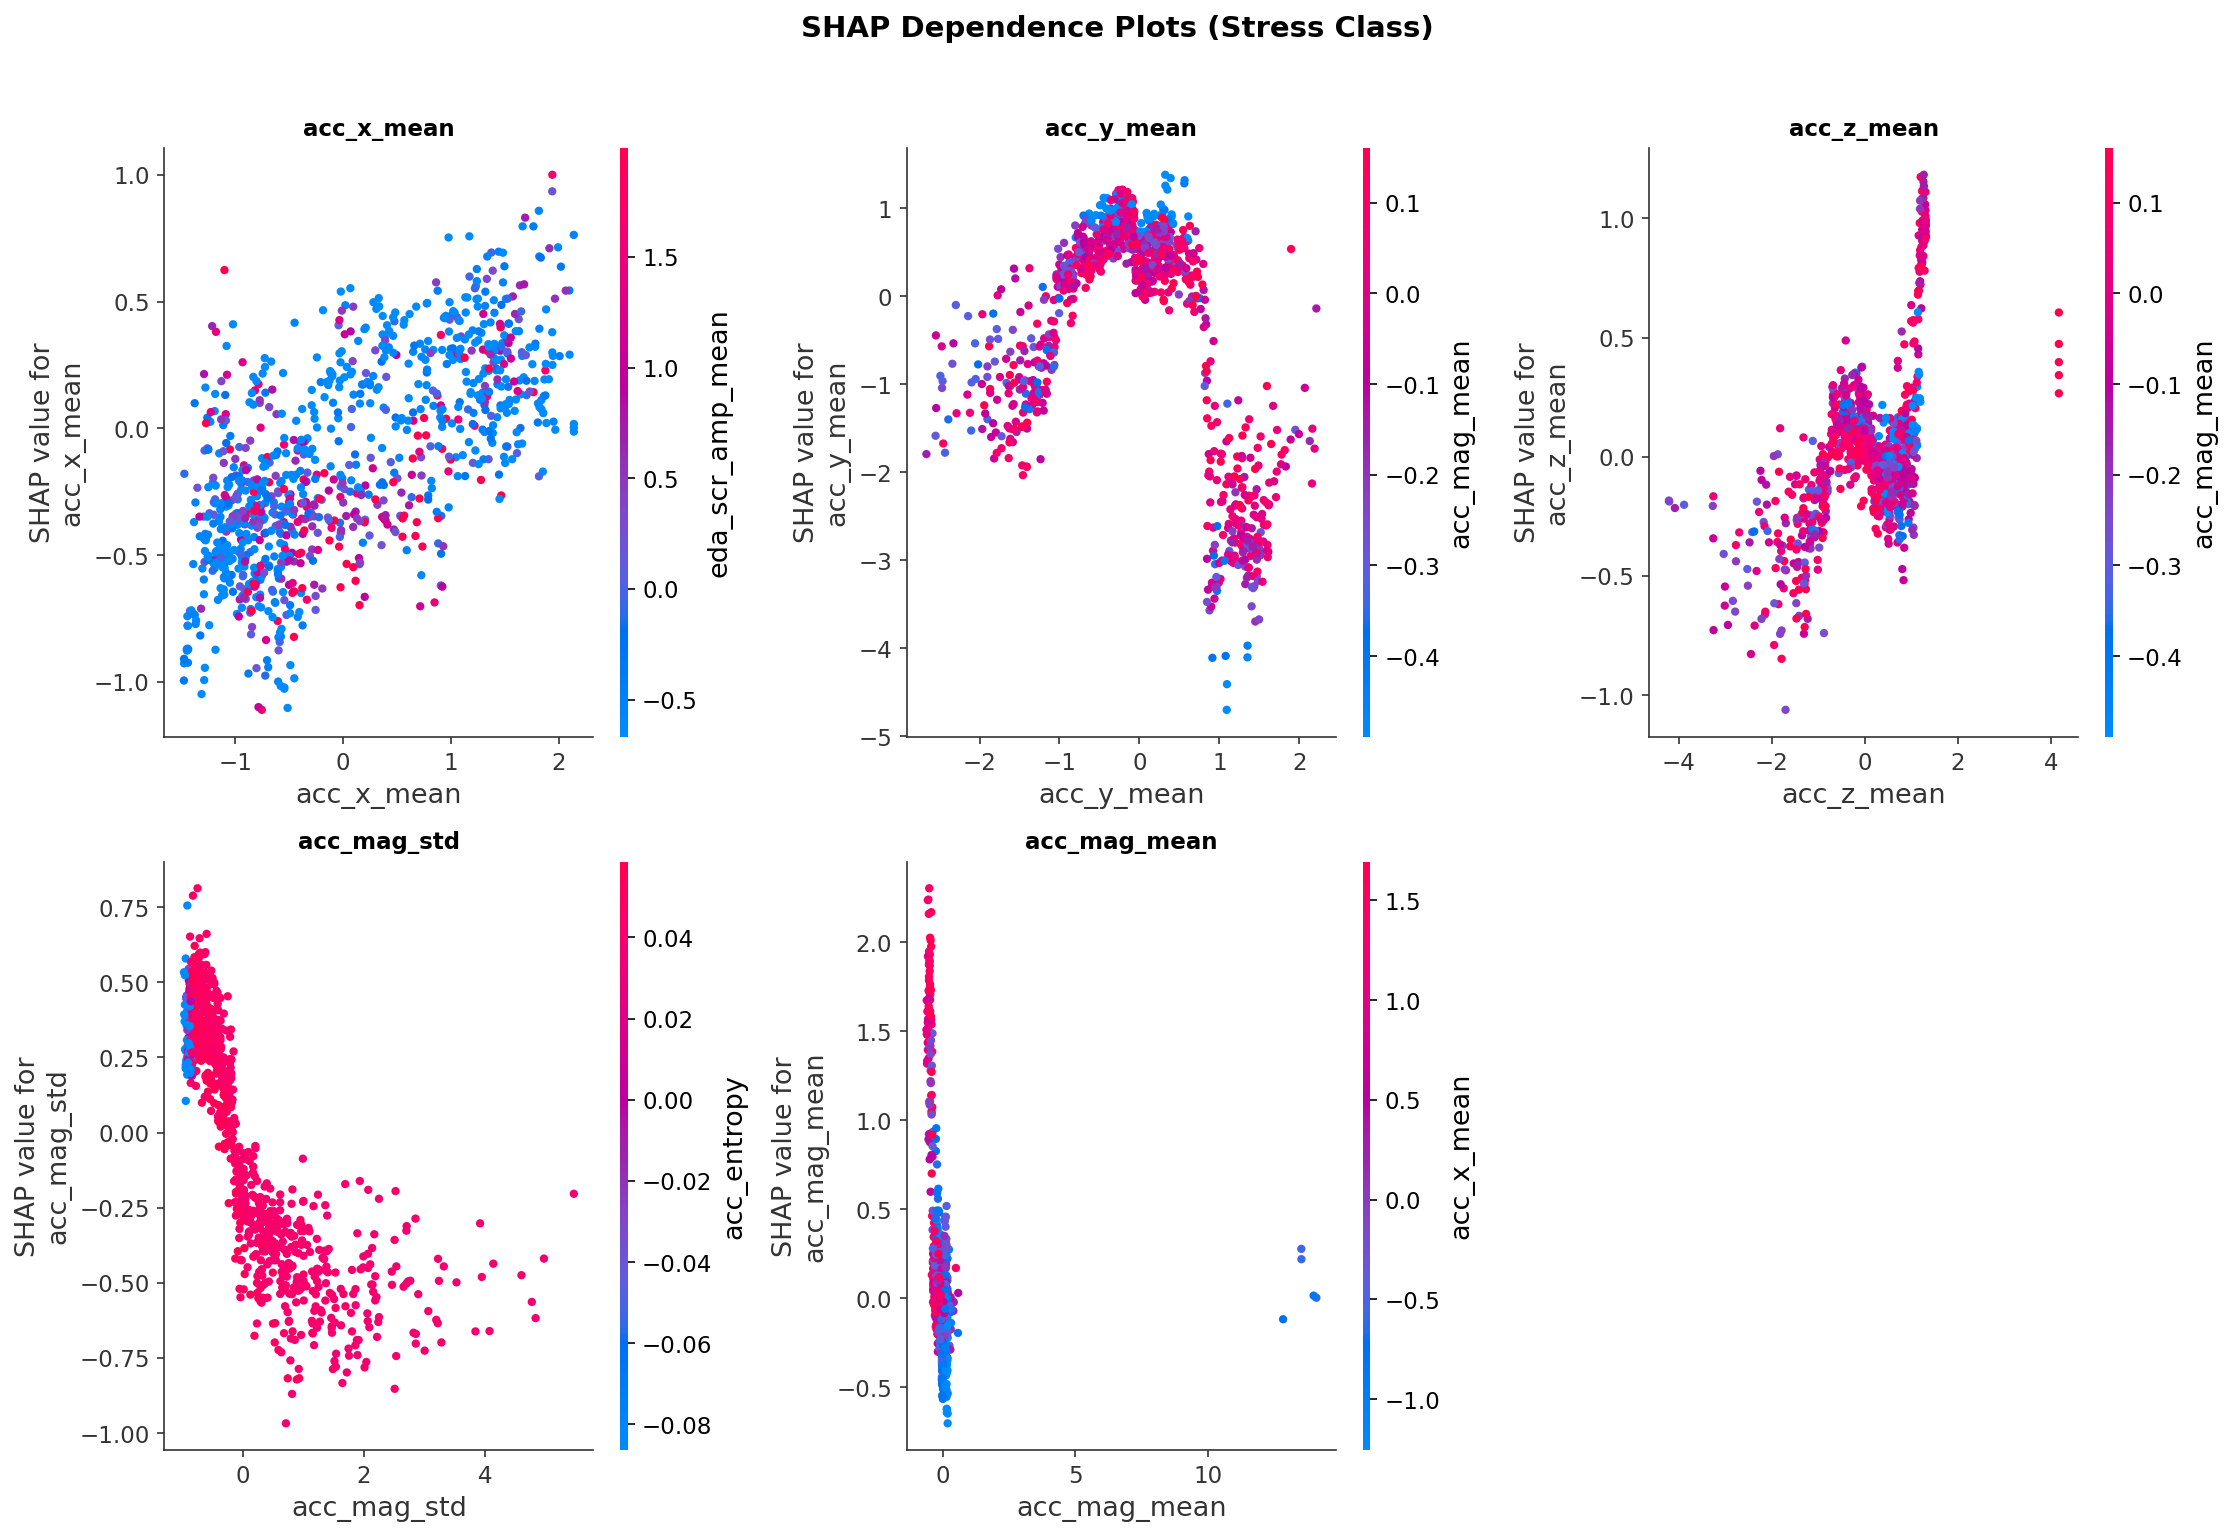

In [15]:
# SHAP dependence plots for top features
# Use Stress class (index 5)
stress_idx = list(le.classes_).index('Stress')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feat in enumerate(top_features[:5]):
    shap.dependence_plot(feat, shap_values_xgb[:, :, stress_idx], X_sample, show=False, ax=axes[i])
    axes[i].set_title(f'{feat}', fontsize=11, fontweight='bold')

# Remove empty subplot
axes[5].axis('off')

plt.suptitle('SHAP Dependence Plots (Stress Class)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_PATH / 'shap_dependence_plots.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# 8.4 Compare with RF Feature Importance
print("\n" + "="*60)
print("8.4 COMPARISON: SHAP vs RF FEATURE IMPORTANCE")
print("="*60)

# RF built-in importance
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'rf_importance': rf_model.feature_importances_
}).sort_values('rf_importance', ascending=False)

# SHAP importance
shap_overall = shap_df['Overall'].reset_index()
shap_overall.columns = ['feature', 'shap_importance']

# Merge
comparison = rf_importance.merge(shap_overall, on='feature')
comparison['rf_rank'] = range(1, len(comparison) + 1)
comparison['shap_rank'] = comparison['shap_importance'].rank(ascending=False).astype(int)
comparison['rank_diff'] = abs(comparison['rf_rank'] - comparison['shap_rank'])

comparison.to_csv(OUTPUT_PATH / 'shap_vs_rf_comparison.csv', index=False)

print("\nTop 15 Features Comparison:")
print(comparison.head(15)[['feature', 'rf_importance', 'shap_importance', 'rf_rank', 'shap_rank']].to_string(index=False))


8.4 COMPARISON: SHAP vs RF FEATURE IMPORTANCE

Top 15 Features Comparison:
         feature  rf_importance  shap_importance  rf_rank  shap_rank
      acc_y_mean       0.091911         0.556239        1          2
      acc_x_mean       0.074096         0.582137        2          1
      acc_z_mean       0.050662         0.484971        3          3
         acc_sma       0.050062         0.381711        4          6
    acc_mag_mean       0.043176         0.405039        5          5
     acc_mag_std       0.042075         0.405880        6          4
      acc_energy       0.037900         0.166932        7         15
       acc_y_std       0.033675         0.338835        8          7
        temp_min       0.032140         0.262017        9         10
        temp_max       0.030881         0.215771       10         13
       temp_mean       0.030331         0.133313       11         22
       acc_x_std       0.028499         0.138886       12         18
     acc_mag_min       0.02

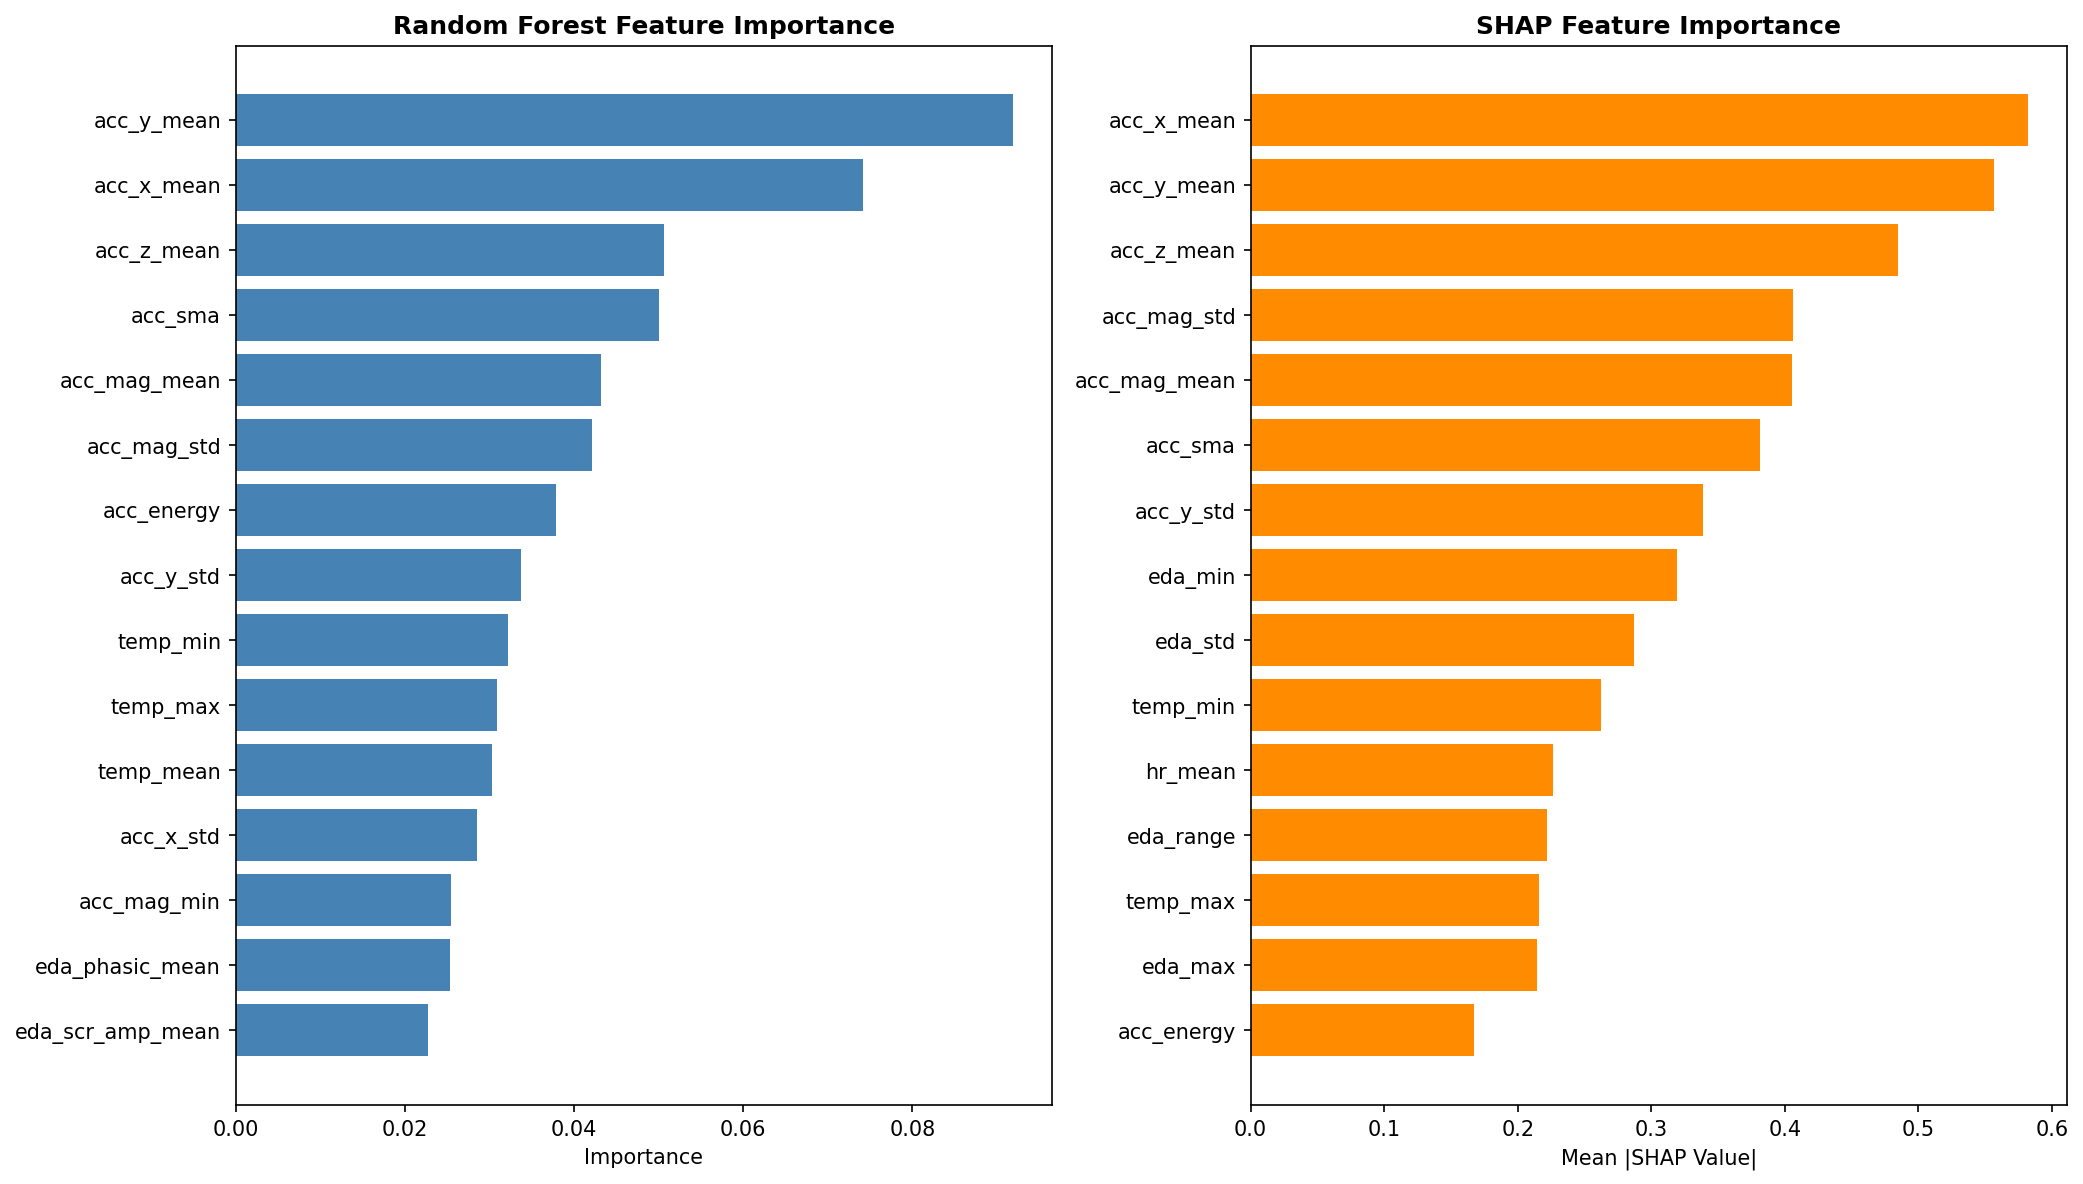

In [17]:
# Visualization: RF vs SHAP importance
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

top_n = 15
top_rf = comparison.head(top_n)

# RF importance
axes[0].barh(top_rf['feature'], top_rf['rf_importance'], color='steelblue')
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest Feature Importance', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()

# SHAP importance
top_shap = comparison.sort_values('shap_importance', ascending=False).head(top_n)
axes[1].barh(top_shap['feature'], top_shap['shap_importance'], color='darkorange')
axes[1].set_xlabel('Mean |SHAP Value|')
axes[1].set_title('SHAP Feature Importance', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'shap_vs_rf_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# Rank correlation
from scipy.stats import spearmanr, kendalltau

spearman_corr, spearman_p = spearmanr(comparison['rf_rank'], comparison['shap_rank'])
kendall_corr, kendall_p = kendalltau(comparison['rf_rank'], comparison['shap_rank'])

print(f"\nRank Correlation between RF and SHAP:")
print(f"  Spearman: {spearman_corr:.4f} (p={spearman_p:.4e})")
print(f"  Kendall:  {kendall_corr:.4f} (p={kendall_p:.4e})")


Rank Correlation between RF and SHAP:
  Spearman: 0.7032 (p=5.9591e-07)
  Kendall:  0.5493 (p=8.5042e-07)


In [19]:
# 8.5 Class-specific important features
print("\n" + "="*60)
print("8.5 CLASS-SPECIFIC FEATURE ANALYSIS")
print("="*60)

class_top_features = {}
for class_name in le.classes_:
    top_5 = shap_df[class_name].sort_values(ascending=False).head(5).index.tolist()
    class_top_features[class_name] = top_5
    print(f"\n{class_name}:")
    for i, feat in enumerate(top_5, 1):
        print(f"  {i}. {feat}: {shap_df.loc[feat, class_name]:.4f}")

# Save class-specific features
class_features_df = pd.DataFrame(class_top_features)
class_features_df.index = [f'Rank_{i+1}' for i in range(5)]
class_features_df.to_csv(OUTPUT_PATH / 'class_specific_top_features.csv')


8.5 CLASS-SPECIFIC FEATURE ANALYSIS

Aerobic:
  1. acc_mag_std: 1.0384
  2. acc_y_mean: 0.5128
  3. acc_sma: 0.4928
  4. acc_y_std: 0.4299
  5. acc_entropy: 0.3701

Amusement:
  1. eda_std: 1.1020
  2. eda_range: 0.7556
  3. eda_min: 0.6805
  4. acc_energy: 0.4267
  5. acc_z_mean: 0.3967

Anaerobic:
  1. acc_y_mean: 0.9057
  2. acc_sma: 0.5820
  3. acc_y_std: 0.5100
  4. acc_mag_std: 0.4702
  5. acc_x_mean: 0.3210

Baseline:
  1. acc_z_mean: 1.4472
  2. acc_x_mean: 0.7037
  3. acc_y_std: 0.6178
  4. eda_min: 0.5129
  5. acc_mag_mean: 0.5029

Emotion:
  1. acc_x_mean: 1.6387
  2. acc_mag_mean: 0.8724
  3. acc_y_mean: 0.4413
  4. acc_z_mean: 0.3864
  5. temp_min: 0.3804

Stress:
  1. acc_y_mean: 1.0222
  2. acc_sma: 0.3774
  3. acc_mag_std: 0.3605
  4. acc_x_mean: 0.3536
  5. acc_mag_mean: 0.2864


In [20]:
# Summary
print("\n" + "="*60)
print("STEP 8 COMPLETE: Interpretability")
print("="*60)

print("\nOverall Top 10 Features (SHAP):")
for i, (feat, val) in enumerate(shap_df['Overall'].head(10).items(), 1):
    print(f"  {i}. {feat}: {val:.4f}")

print(f"\nRF-SHAP Rank Correlation: {spearman_corr:.4f}")

print("\nOutputs Saved:")
print("  - shap_importance_by_class.csv")
print("  - shap_vs_rf_comparison.csv")
print("  - class_specific_top_features.csv")

print("\nFigures:")
print("  - shap_summary_bar.png")
print("  - shap_by_class.png")
print("  - shap_heatmap_by_class.png")
print("  - shap_waterfall_examples.png")
print("  - shap_dependence_plots.png")
print("  - shap_vs_rf_importance.png")

print("="*60)


STEP 8 COMPLETE: Interpretability

Overall Top 10 Features (SHAP):
  1. acc_x_mean: 0.5821
  2. acc_y_mean: 0.5562
  3. acc_z_mean: 0.4850
  4. acc_mag_std: 0.4059
  5. acc_mag_mean: 0.4050
  6. acc_sma: 0.3817
  7. acc_y_std: 0.3388
  8. eda_min: 0.3194
  9. eda_std: 0.2871
  10. temp_min: 0.2620

RF-SHAP Rank Correlation: 0.7032

Outputs Saved:
  - shap_importance_by_class.csv
  - shap_vs_rf_comparison.csv
  - class_specific_top_features.csv

Figures:
  - shap_summary_bar.png
  - shap_by_class.png
  - shap_heatmap_by_class.png
  - shap_waterfall_examples.png
  - shap_dependence_plots.png
  - shap_vs_rf_importance.png
